In [1]:
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2  
import random  
import time  

# Global Variable

In [2]:
path_train = 'E:/data/DIV2K/DIV2K_train_HR/'  
path_test = 'E:/data/DIV2K/DIV2K_train_HR/'  
path_model = 'D:/model/csr/model/'
image_channel = 1
device = T.device("cuda:0") if T.cuda.is_available() else T.device("cpu")
num_workers = 0
batch_size = 16

# Data

In [3]:
class Dataset_(Dataset):
    #
    def __init__(self, path=path_train, image_channel=image_channel, batch_size=batch_size):
        self.path = path
        self.list_image = os.listdir(path)
        if image_channel == 1:
            self.color_mode = 0
        else:
            self.color_mode = 1
        # self.patch_size = patch_size
        self.patch_size = [random.randint(8, 128), random.randint(8, 128)]
        self.batch_size = batch_size
        self.transpose = True
    #
    def __getitem__(self, idx):
        #
        image_hr = cv2.imdecode(np.fromfile(self.path+self.list_image[idx//self.batch_size], dtype=np.uint8), self.color_mode)
        h, w = image_hr.shape[:2]
        #
        scale_h, scale_w = random.randint(1, 8), random.randint(1, 8)
        h_lr, w_lr = round(h/scale_h), round(w/scale_w)
        scale = T.tensor([h_lr/h, w_lr/w]).reshape([2,1,1])
        #
        image_lr = cv2.resize(image_hr, dsize=(w_lr, h_lr))
        image_lr = cv2.resize(image_lr, dsize=(w, h))
        #
        image_lr, image_hr = self.get_patch(image_lr, image_hr)
        #
        image_lr = image_lr.reshape([*image_lr.shape[:2],-1]).transpose([2, 0, 1]).astype(np.float32) / 255.0
        image_hr = image_hr.reshape([*image_hr.shape[:2],-1]).transpose([2, 0, 1]).astype(np.float32) / 255.0
        #
        image_lr, image_hr = self.data_augmentation(image_lr, image_hr)
        #
        image_lr = T.from_numpy(image_lr)
        image_hr = T.from_numpy(image_hr)
        return image_lr, image_hr, scale
    #
    def __len__(self):
        return len(self.list_image) * self.batch_size
    #
    def get_patch(self, image_lr, image_hr):
        h_min, w_min = random.randint(0, image_lr.shape[0]-self.patch_size[0]), random.randint(0, image_lr.shape[1]-self.patch_size[1])
        image_lr_patch = image_lr[h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1], ...]
        image_hr_patch = image_hr[h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1], ...]
        return image_lr_patch, image_hr_patch
    #
    def data_augmentation(self, image_lr, image_hr): 
        if random.randint(0, 1):
            image_lr = image_lr[..., ::-1, :]
            image_hr = image_hr[..., ::-1, :]
        if random.randint(0, 1):
            image_lr = image_lr[..., :, ::-1]
            image_hr = image_hr[..., :, ::-1]
        if self.transpose:
            image_lr = image_lr.transpose([0, 2, 1])
            image_hr = image_hr.transpose([0, 2, 1])
        return image_lr.copy(), image_hr.copy()
    #
    def collate_fn(self, batch):
        image_lr, image_hr, scale = zip(*batch)
        self.patch_size = [random.randint(8, 128), random.randint(8, 128)]
        self.transpose = random.randint(0, 1)
        return T.stack(image_lr, 0), T.stack(image_hr, 0), T.stack(scale, 0)

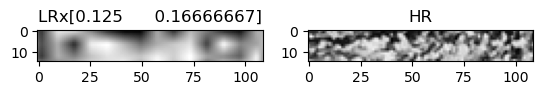

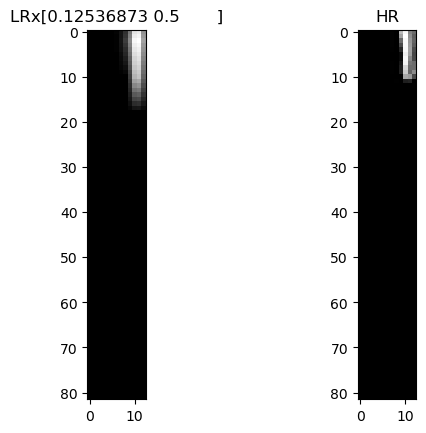

In [4]:
dataset = Dataset_()
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)

for n, (image_lr, image_hr, label) in enumerate(dataloader):
    #
    image_lr = image_lr.permute([0, 2, 3, 1]).squeeze().numpy()
    image_hr = image_hr.permute([0, 2, 3, 1]).squeeze().numpy()
    scale = label.squeeze().numpy()
    #
    plt.subplot(1, 2, 1), plt.imshow(image_lr, 'gray'), plt.title('LRx'+ str(scale))
    plt.subplot(1, 2, 2), plt.imshow(image_hr, 'gray'), plt.title('HR')
    plt.show()
    #
    if n == 1:
        break

# Network Structure

In [5]:
class CA(nn.Module):

    def __init__(self, channel, reduction):
        super(CA, self).__init__()
        self.conv1 = nn.Conv2d(channel+2,channel//reduction,1)
        self.conv2 = nn.Conv2d(channel//reduction,channel,1)

    def forward(self, x, scale):
        means = T.mean(x, [2,3], True)
        means = T.cat([means, scale], 1)
        y = self.conv1(means)
        y = F.relu(y)
        y = self.conv2(y)
        y = F.sigmoid(y)
        return x * y

In [6]:
class RCAB(nn.Module):

    def __init__(self, channel, reduction):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(channel,channel,3,padding=1)
        self.conv2 = nn.Conv2d(channel,channel,3,padding=1)
        self.ca = CA(channel, reduction)

    def forward(self, x, scale):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.ca(y, scale)
        return x + y

In [7]:
class RG(nn.Module):

    def __init__(self, channel, reduction, numRCAB):
        super(RG,self).__init__()
        self.RCAB_list = nn.ModuleList()
        for i in range(numRCAB):
            self.RCAB_list.append(RCAB(channel, reduction))
        self.conv = nn.Conv2d(channel,channel,3,padding=1)

    def forward(self, x, scale):
        y = x
        for rcab in self.RCAB_list:
            y = rcab(y, scale)
        y = self.conv(y) 
        return x + y

In [8]:
class RCAN(nn.Module):

    def __init__(self, channel=64, reduction=16, numRG=10, numRCAB=20):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(image_channel,channel,3,padding=1)
        self.RG_list = nn.ModuleList()
        for _ in range(numRG):
            self.RG_list.append(RG(channel, reduction,numRCAB))
        self.conv2= nn.Conv2d(channel,channel,3,padding=1)
        self.conv3 = nn.Conv2d(channel,image_channel,3,padding=1)

    def forward(self, x, scale):
        x = self.conv1(x)
        y = x
        for rg in self.RG_list:
            y = rg(y, scale)
        y = self.conv2(y)
        y = x + y
        y = self.conv3(y)
        return y

# Show

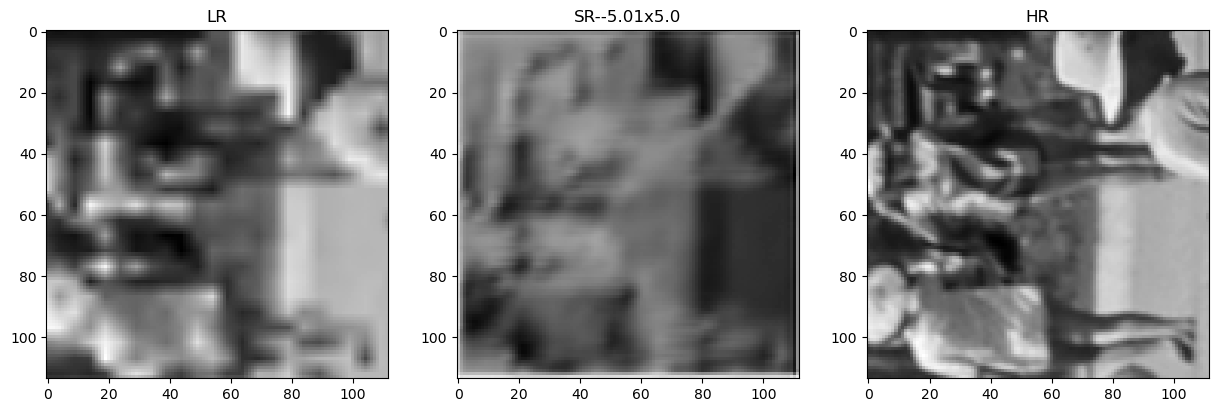

In [9]:
@T.no_grad()
def show_image1(net=None):
    #
    if net==None:
        net = RCAN().to(device)
    net.eval()
    #
    plt.figure(figsize=(15, 5))
    dataloader = DataLoader(Dataset_(path=path_test), batch_size=1, shuffle=True, num_workers=0)
    for image_lr, image_hr, scale in dataloader:
        image_sr = net(image_lr.to(device), scale.to(device)).permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy()
        image_lr = image_lr.permute([0, 2, 3, 1]).squeeze().numpy()
        image_hr = image_hr.permute([0, 2, 3, 1]).squeeze().numpy()
        plt.subplot(1, 3, 1), plt.imshow(image_lr, 'gray'), plt.title('LR')
        plt.subplot(1, 3, 2), plt.imshow(image_sr, 'gray'), plt.title('SR--'+str(round(1/scale.squeeze().cpu().numpy()[0].item(), 2))+'x'+str(round(1/scale.squeeze().cpu().numpy()[1].item(), 2)))
        plt.subplot(1, 3, 3), plt.imshow(image_hr, 'gray'), plt.title('HR')
        plt.show()
        break
    net.train()


show_image1()

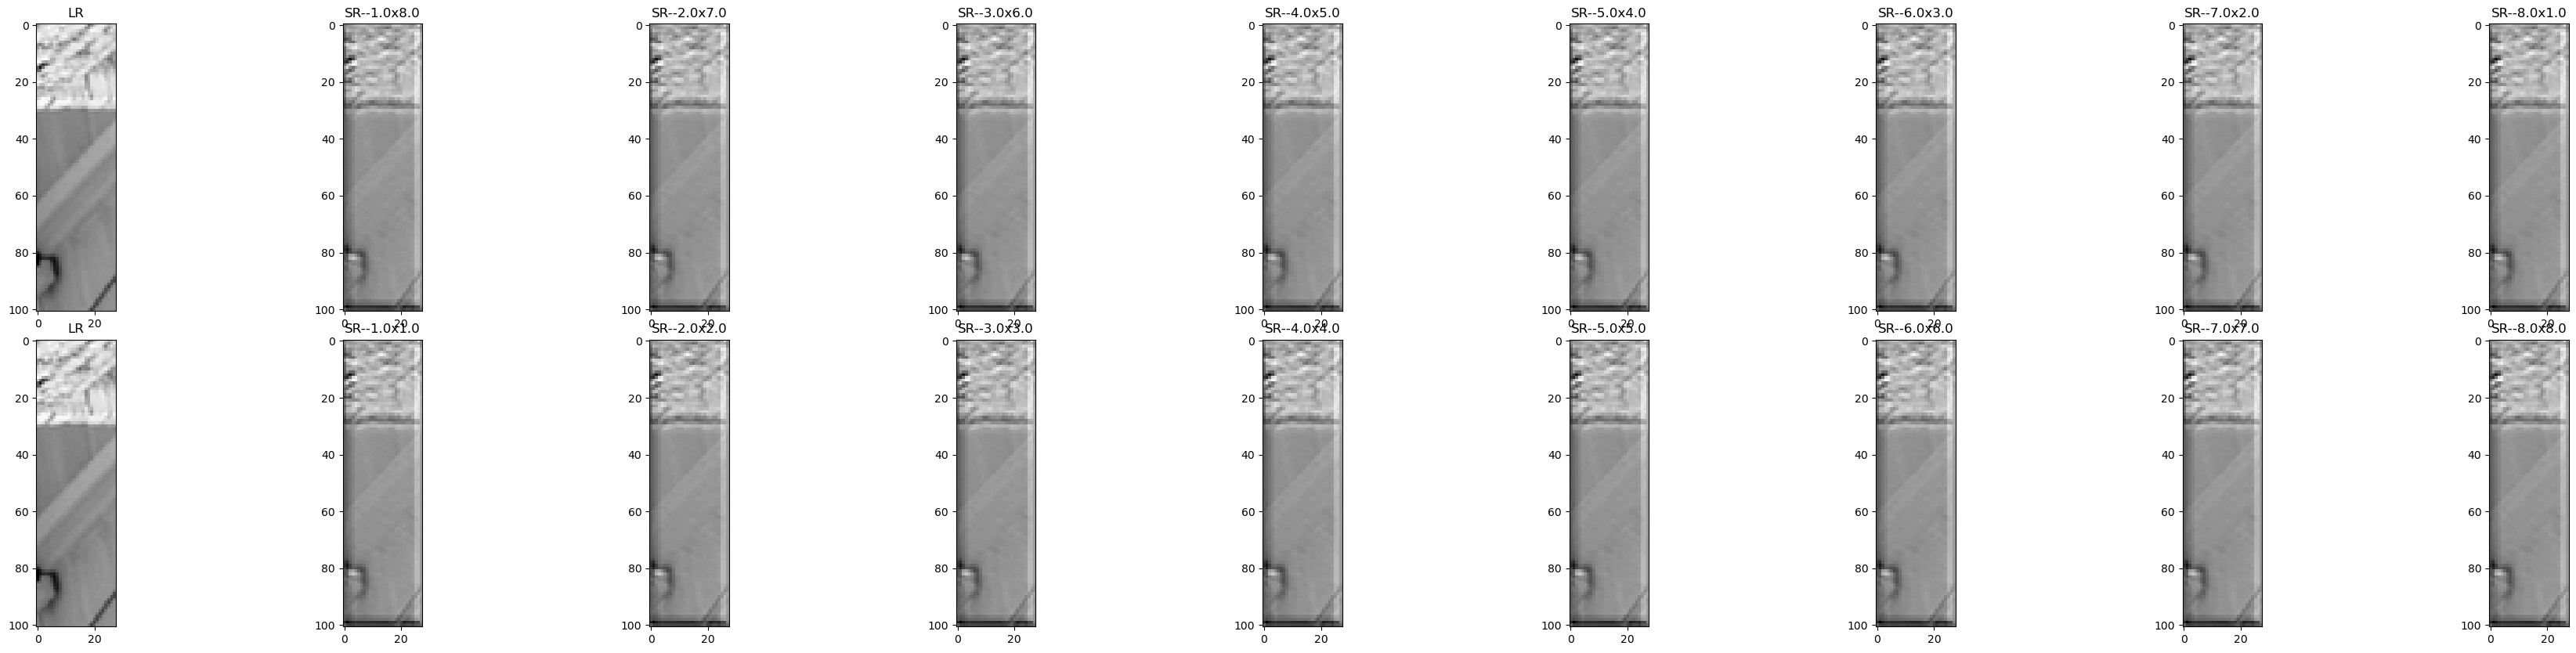

In [10]:
@T.no_grad()
def show_image2(net=None, scale_num=8, scale_max=8):
    #
    if net==None:
        net = RCAN().to(device)
    net.eval()
    #
    plt.figure(figsize=(5*(scale_num+1), 5*2))
    gs = plt.GridSpec(2, scale_num+1)
    gs.update(wspace=0.1, hspace=0.1)
    #
    dataset = Dataset_(path=path_test)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)
    for _, image_hr, _ in dataloader:
        image_show = image_hr.permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy()
        image_lr = image_hr.repeat([scale_num, 1, 1, 1]).to(device)
        scale_min2max = 1 / T.linspace(1, scale_max, scale_num, dtype=T.float32, device=device).reshape([-1, 1, 1, 1])
        scale_max2min = 1 / T.linspace(scale_max, 1, scale_num, dtype=T.float32, device=device).reshape([-1, 1, 1, 1])
        scales = [T.cat([scale_min2max, scale_max2min], dim=1), T.cat([scale_min2max, scale_min2max], dim=1)]
        for i, scale in enumerate(scales):
            plt.subplot(gs[i*(scale_num+1)]), plt.imshow(image_show, 'gray'), plt.title('LR')
            image_srs = net(image_lr, scale)#.permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy()
            for j in range(scale_num):
                image_sr = image_srs[j,:,:,:].permute([1, 2, 0]).squeeze().cpu().detach().numpy()
                plt.subplot(gs[i*(scale_num+1)+j+1]), plt.imshow(image_sr, 'gray'), plt.title('SR--'+str(round(1/scale[j].cpu().numpy()[0].item(), 2))+'x'+str(round(1/scale[j].cpu().numpy()[1].item(), 2)))
        plt.show()
        break
    net.train()


show_image2()

# Train

In [11]:
def train(epoch_num, load_model, batch_size):
    #
    net = RCAN().to(device)
    net.train()
    optimizer = T.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))
    dataloader = DataLoader(Dataset_(), batch_size=batch_size, shuffle=True, num_workers=num_workers)
    if load_model == True:
        net.load_state_dict(T.load(path_model+'net.pt'))
        optimizer.load_state_dict(T.load(path_model+'optimizer.pt'))
        with open(path_model+'epoch.txt', 'r') as f:
            epoch_start = int(f.read())
    else:
        epoch_start = -1
    #
    iteration_num = 0
    time_start = time.time()
    for epoch in range(epoch_start+1, epoch_num):
        for image_lr, image_hr, scale in dataloader:
            iteration_num += 1      
            image_lr, image_hr, scale = image_lr.to(device), image_hr.to(device), scale.to(device)
            image_sr = net(image_lr, scale) 
            optimizer.zero_grad()
            loss = T.mean(T.abs(image_sr - image_hr))
            loss.backward()
            optimizer.step()
        #
        if(epoch % 1 == 0):
            print('Epoch: ', epoch, ', Iteration: ', iteration_num, ', Loss: ', loss.item(), ', Time: ', time.time() - time_start)
            T.save(net.state_dict(), path_model+'net.pt')
            T.save(optimizer.state_dict(), path_model+'optimizer.pt')
            with open(path_model+'epoch.txt', 'w') as f:
                f.write(str(epoch))
            show_image1(net)                         
            time_start = time.time()

In [12]:
# train(epoch_num=1, load_model=False, batch_size=batch_size)  #第一个epoch，保存模型， 记得注释

In [13]:
# train(epoch_num=200, load_model=True, batch_size=batch_size)  #后面每次训练就可以读取之前的模型，继续训练了

# Test

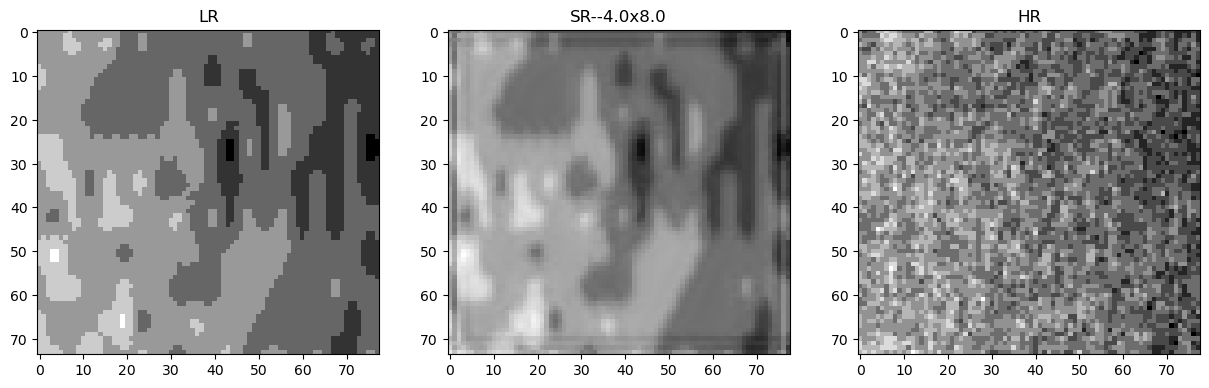

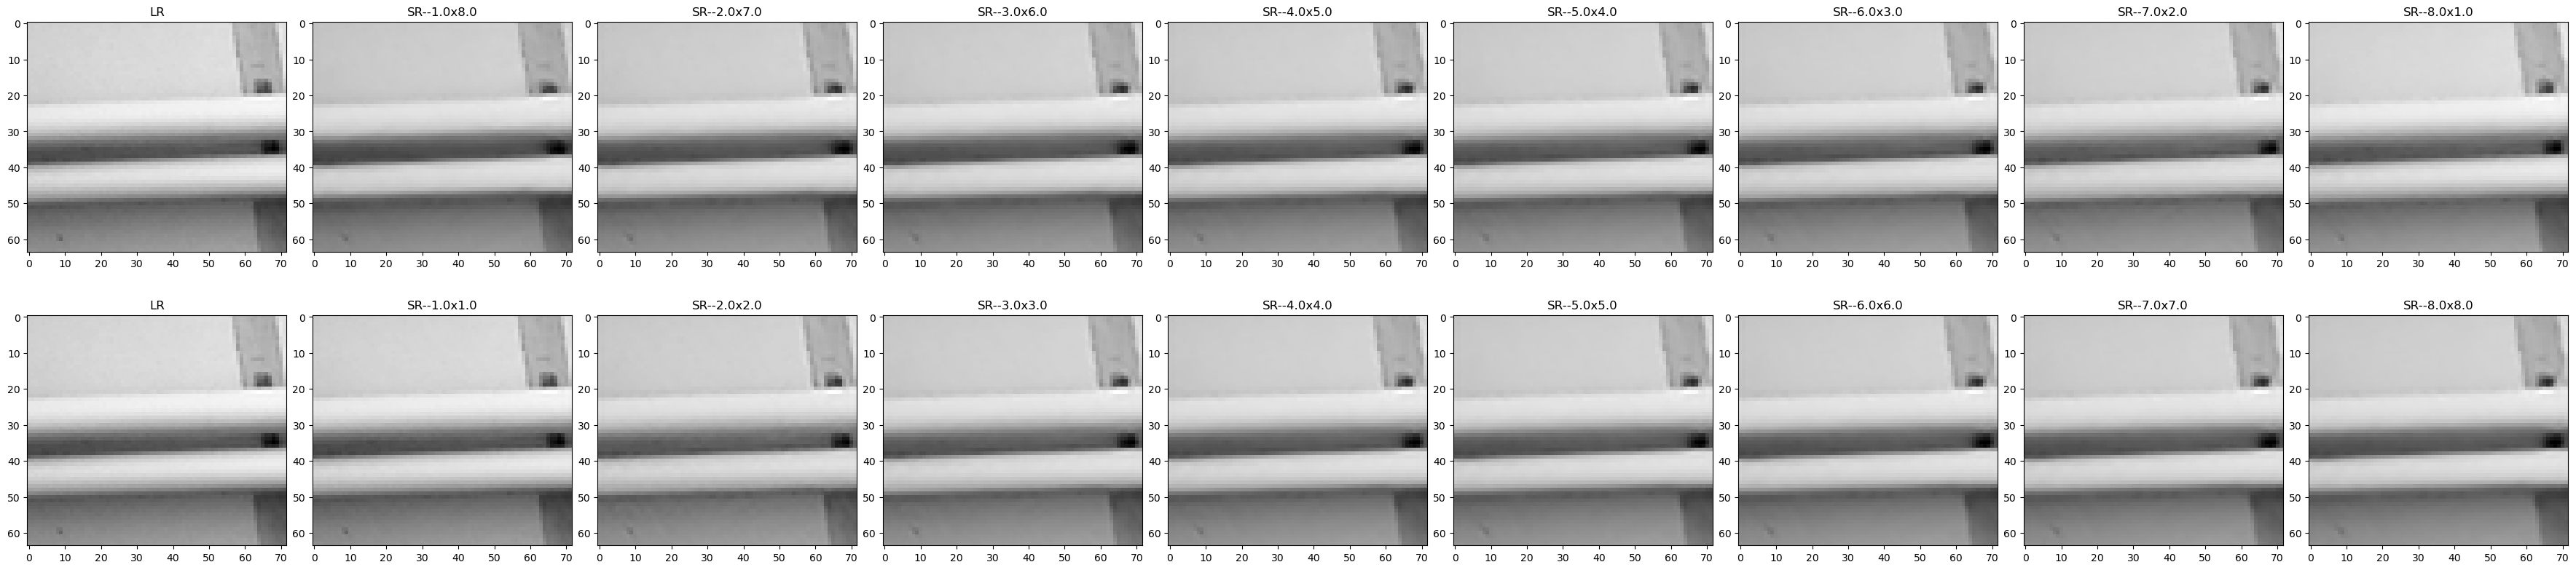

In [14]:
net = RCAN().to(device)
net.load_state_dict(T.load(path_model+'net.pt'))
show_image1(net)
show_image2(net)

# Export

In [15]:
net = RCAN().to(device)
net.eval()
net.load_state_dict(T.load(path_model+'net.pt'))
# net.half()

T.onnx.export(net, (T.randn([1,1,1024,1024],dtype=T.float32,device=device), T.randn([1,2,1,1],dtype=T.float32,device=device)), path_model+'net.onnx', input_names=['image_lr', 'scale'], output_names=['image_sr'])
